In [1]:
from neo4j import *

In [2]:
uri = "bolt://localhost:7687"
user = "neo4j"
password = "letmein"

driver = GraphDatabase.driver(uri, auth=(user, password))

# Examine the Files - Colors

Starting with colors.csv, let's examine the structure. In VSCode, the files shows like this:

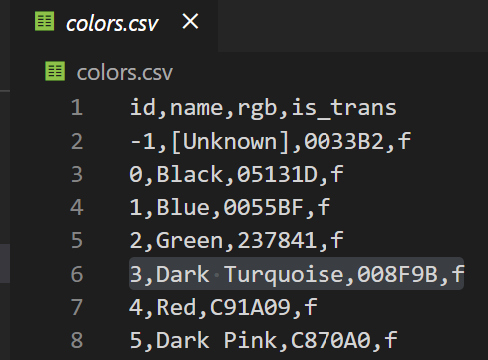

There are 4 items to import: the id, the name of the color, the RGB value, and a transparency boolean. There are no references to other nodes in this file. Therefore, no other nodes need to be extracted and created from this file, nor will any relationships need to be created to other nodes (none exist anyway). The nodes to be created will have a label of :Color. Theses nodes will also have 4 properties: name, rgb, transparency, and id. The id values shown here are really "throw away". They do not add any real value to the graph. They will be kept until all the data is loaded into the database, and then deleted. 

# Defining Contraints

In order to ensure fast and efficient loading into Neo4j, we will first create a CONSTRAINT on the id property for the color label nodes. Copy and paste the constraint below into the Neo4j browser window.

CREATE CONSTRAINT ON (c:Color) ASSERT c.id IS UNIQUE

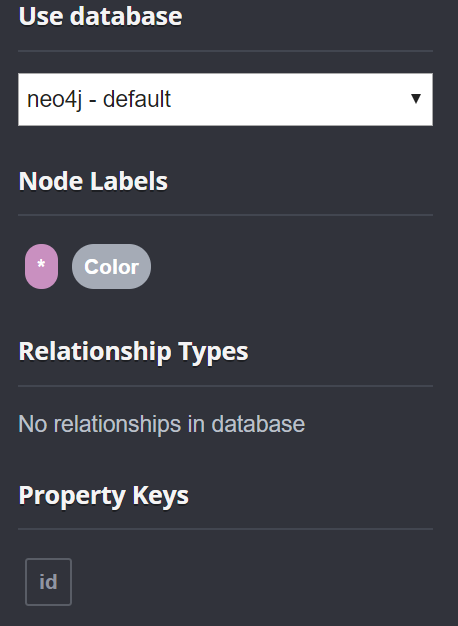

Notice that the database is aware that it will be storing nodes with a label of Color and that some nodes will have a propert key of id.

In [31]:
colors_load="""
USING PERIODIC COMMIT 1000
LOAD CSV WITH HEADERS FROM 'file:///colors.csv' AS row
MERGE (c:Color {id:row.id})
ON CREATE SET
c.name = row.name,
c.rgb = row.rgb,
c.transparent = row.is_trans
"""

In [32]:
with driver.session() as session:
    results = session.run(colors_load)

Running the 2 previous cells creates the cypher statements to send to Neo4j and sends the statements to import the data. If sucessful, new nodes will be created in the database and the additional property keys will also be created.

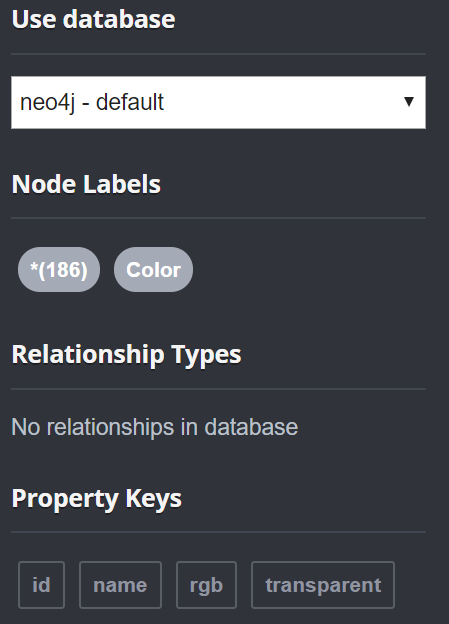

# Examine the Files - Elements
The elements.csv file has 3 columns as shown below: element_id, part_num, color_id. The color_id column is in reference to the :Color nodes that were loaded in the previous step. The part_num is in reference to the :Part nodes that have not been loaded as of yet. That is OK, we will create those nodes upon import of this file. The :Part nodes listed here can be thought of the "shape" or the "mold" used to create the element. For example, a 1x2 plate can come in 5 different colors. The 1x2 plate would have 1 part number, but have 5 unique element_id numbers for the 5 different color combinations.

To load this file, we are creating 2 new node labels (:Element) and (:Part) and 3 relationships between those 2 nodes and the existing (:Color) node label. Before we can load the data, we must again add some constraints to the database to speed the loading operation. Copy and paste the two CONSTRAINT statements shown below.

CREATE CONSTRAINT ON (e:Element) ASSERT e.id IS UNIQUE

CREATE CONSTRAINT ON (p:Part) ASSERT p.id IS UNIQUE

After adding the 2 constraints, the database should look like this. We can now write our import statements for the elements.

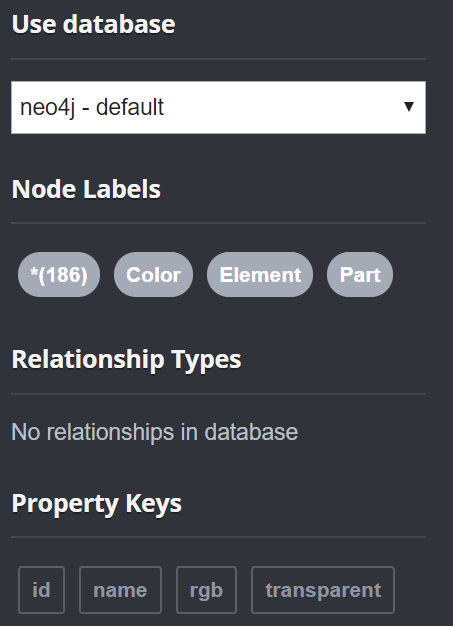

In [33]:
elements_load="""
USING PERIODIC COMMIT 1000
LOAD CSV WITH HEADERS FROM 'file:///elements.csv' AS row
MERGE (c:Color {id:row.color_id})
MERGE (e:Element {id:row.element_id})
MERGE (p:Part {id:row.part_num})
MERGE (p)-[:HAS_COLOR]->(c)
MERGE (p)-[:HAS_ELEMENT]->(e)
MERGE (e)-[:IS_COLORED]-(c)
"""

In [34]:
with driver.session() as session:
    results = session.run(elements_load)

The above import should only take a few seconds to load. When finished we should have almost 79k nodes and 153k new relationships.

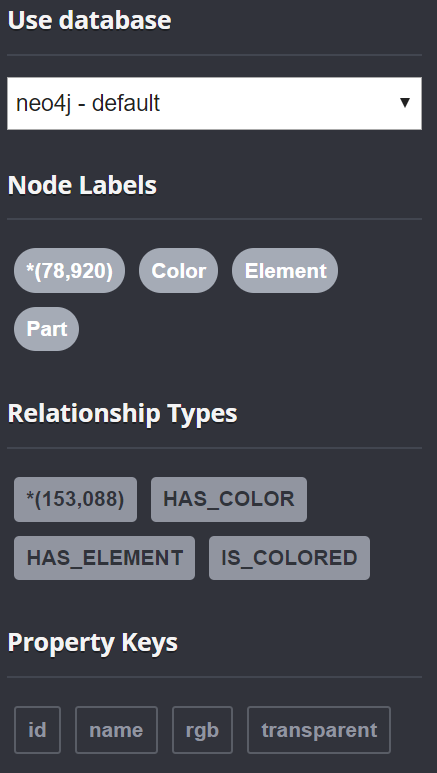

# Examine the files - Inventories

The inventories.csv file has three columns as shown here with columns: id, version, and set_num. Set_num will need to be a new node in the database. Each set can have more than one version of its inventory. This is often due to Lego slightly changing the mold of a part. Perhaps version 1 had revision a, and version 2 has revision b of the part in question.

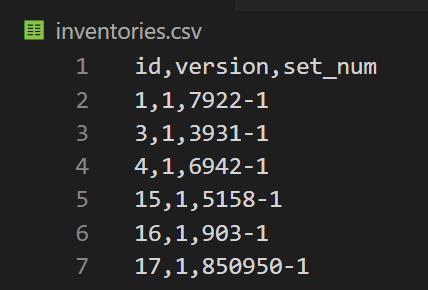

Copy and paste the following CONSTRAINTs to prepare the database

CREATE CONSTRAINT ON (s:Set) ASSERT s.id IS UNIQUE

CREATE CONSTRAINT ON (i:Inventory) ASSERT i.id IS UNIQUE

### Update
Upon further investigation of inventories.csv, it appears that this file is merely a summation of all inventories, regardless of the type. This means that although the column is labeled "set_num", it also includes mini-figures or collections of sets. To make things easier to follow, inventories.csv will be skipped for now, or possibly omitted entirely.

# Examine the files - Parts and Categories and Relationships

Since we have already created the CONSTRAINT for (:Part), let's focus on parts.csv. It contains 4 columns: part_num, name, part_cat_id and part_material as shown below. We already know that part_num will be the id of the node. name and material will be properties of (:Part). part_cat_id will need to be a new node with a new constraint and a new relationship between the nodes.

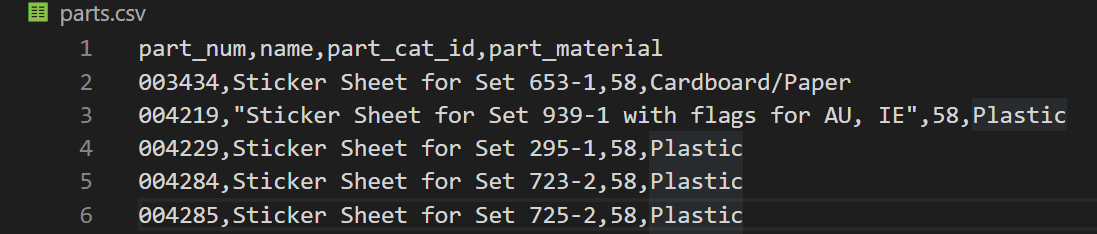

Copy and paste the following CONSTRAINTs to prepare the database

CREATE CONSTRAINT ON (pc:PartCategory) ASSERT pc.id IS UNIQUE

In [35]:
parts_load="""
USING PERIODIC COMMIT 1000
LOAD CSV WITH HEADERS FROM 'file:///parts.csv' AS row
MERGE (p:Part {id:row.part_num})
MERGE (pc:PartCategory {id:row.part_cat_id})
MERGE (p)-[:IS_OF_TYPE]->(pc)
ON CREATE SET
p.name = row.name,
p.material = row.part_material
"""

In [36]:
with driver.session() as session:
    results = session.run(parts_load)

We should now be around 92K nodes and 190K relationships.
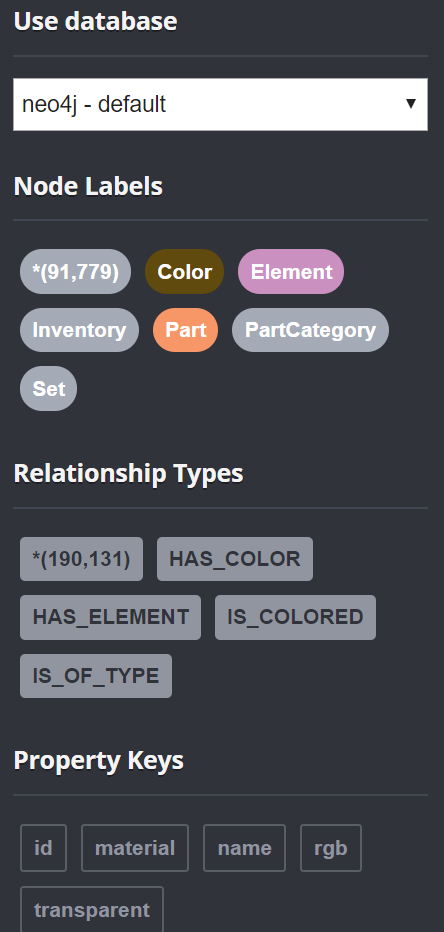

## Categories
The Part categories should be a straight forward import. The file only has 2 columns: id and name.

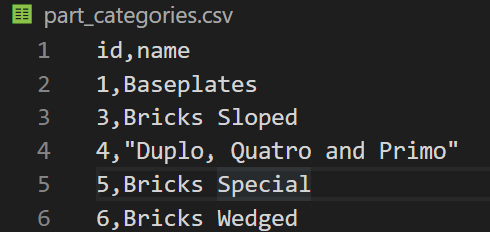

We already have the constraint on (:PartCategory), so let's get straight to the import!

In [37]:
pc_load="""
USING PERIODIC COMMIT 1000
LOAD CSV WITH HEADERS FROM 'file:///part_categories.csv' AS row
MERGE (pc:PartCategory {id:row.id})
SET pc.name = row.name
"""

In [38]:
with driver.session() as session:
    results = session.run(pc_load)

### Relationships

This import will be a bit tricky. This file contains 3 columns: rel_type, child_part_num and parent_part_num. The part_num columns already refer to existing nodes with the (:Part) label. Here we need to create a part to part relationship, but the relationship type will vary depending upon the character in the rel_type column.

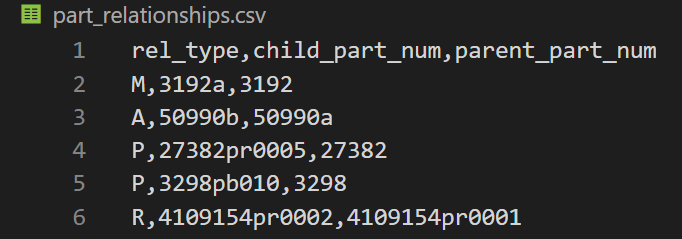

There are 6 different rel_types:

P: Used where the image (P)rinted on the part is different

R: Is used where parts are meant to be Pai(R)ed together to be a sort of a 2-piece subassembly

B: Is a Su(b)-part of a small subassembly

M: Signifies a change in (M)old where the old version has been superceded

T: Signifies a Pa(T)tern difference where there are multiple color combinations

A: Signifies an (A)lternate part which can be substituted

To make things straight-forward, the same relationship type will be created, but a relationship property will be assigned based on the rel_type column. Once loaded, the graph will be refactored to display the correct relationship type.


In [39]:
pr_load="""
USING PERIODIC COMMIT 1000
LOAD CSV WITH HEADERS FROM 'file:///part_relationships.csv' AS row
MERGE (cp:Part {id:row.child_part_num})
MERGE (pp:Part {id:row.parent_part_num})
MERGE (cp)-[tr:TEMP_REL]->(pp)
ON CREATE SET
tr.rel = row.rel_type
"""

In [40]:
with driver.session() as session:
    results = session.run(pr_load)

### Relationships Refactor

There should be ~211K relationships at this point. The [:TEMP_REL] does not tell us much. Let create six new relationship types in its place before deletion.

In [41]:
rel_p="""
MATCH (p1:Part)-[r:TEMP_REL]->(p2:Part)
WHERE r.rel = 'P'
MERGE (p2)<-[:HAS_PRINTED_VARIANT]-(p1)
"""
with driver.session() as session:
    results = session.run(rel_p)

In [42]:
rel_r="""
MATCH (p1:Part)-[r:TEMP_REL]->(p2:Part)
WHERE r.rel = 'R'
MERGE (p2)-[:PAIRS_WITH]->(p1)
"""
with driver.session() as session:
    results = session.run(rel_r)

In [43]:
rel_b="""
MATCH (p1:Part)-[r:TEMP_REL]->(p2:Part)
WHERE r.rel = 'B'
MERGE (p2)-[:SUB_PART_WITH]->(p1)
"""
with driver.session() as session:
    results = session.run(rel_b)

In [44]:
rel_m="""
MATCH (p1:Part)-[r:TEMP_REL]->(p2:Part)
WHERE r.rel = 'M'
MERGE (p2)-[:SUPERCEDES]->(p1)
"""
with driver.session() as session:
    results = session.run(rel_m)

In [45]:
rel_t="""
MATCH (p1:Part)-[r:TEMP_REL]->(p2:Part)
WHERE r.rel = 'T'
MERGE (p2)<-[:HAS_PATTERN_VARIANT]-(p1)
"""
with driver.session() as session:
    results = session.run(rel_t)

In [46]:
rel_a="""
MATCH (p1:Part)-[r:TEMP_REL]->(p2:Part)
WHERE r.rel = 'A'
MERGE (p2)<-[:HAS_ALTERNATE]-(p1)
"""
with driver.session() as session:
    results = session.run(rel_a)

In [47]:
rel_rel="""
MATCH ()-[rel:TEMP_REL]-()
DETACH DELETE rel
"""
with driver.session() as session:
    results = session.run(rel_rel)

With the Graph refactored, the database should resemble

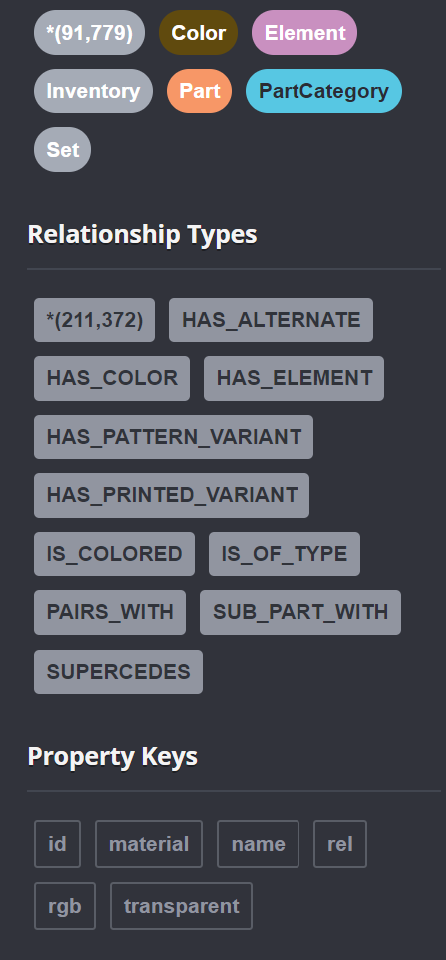

# Themes

Following the same process as the previous files, we have 3 columns in themes.csv: id, name and parent_id.

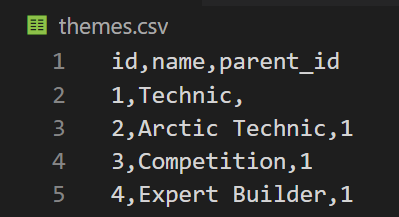

CREATE CONSTRAINT ON (t:Theme) ASSERT t.id IS UNIQUE



In [48]:
theme_load="""
USING PERIODIC COMMIT 1000
LOAD CSV WITH HEADERS FROM 'file:///themes.csv' AS row
MERGE (t1:Theme {id:row.id})
ON CREATE SET
t1.name = row.name
WITH t1, row WHERE row.parent_id IS NOT NULL
MERGE (t2:Theme {id:row.parent_id})
MERGE (t2)-[:HAS_SUBTHEME]->(t1)
"""
with driver.session() as session:
    results = session.run(theme_load)

# Sets

This making sense yet?

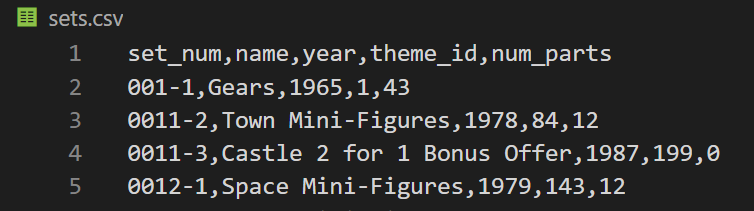

The Set CONSTRAINT was created earlier

In [49]:
sets_load="""
USING PERIODIC COMMIT 1000
LOAD CSV WITH HEADERS FROM 'file:///sets.csv' AS row
MERGE (s:Set {id:row.set_num})
MERGE (t:Theme {id:row.theme_id})
MERGE (s)-[:BELONGS_TO]->(t)
ON CREATE SET
s.name = row.name,
s.year = row.year,
s.pieces = row.num_parts
"""
with driver.session() as session:
    results = session.run(sets_load)

# Minifigs

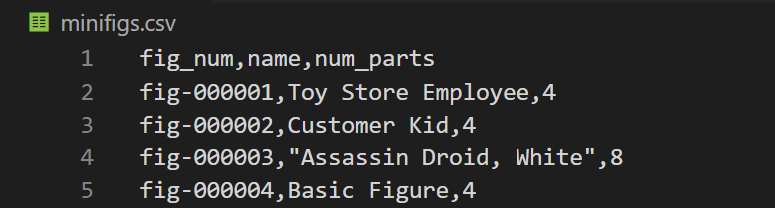

CREATE CONSTRAINT ON (mf:MiniFigure) ASSERT mf.id IS UNIQUE

In [50]:
mf_load="""
USING PERIODIC COMMIT 1000
LOAD CSV WITH HEADERS FROM 'file:///minifigs.csv' AS row
MERGE (mf:MiniFigure {id:row.fig_num})
ON CREATE SET
mf.name = row.name,
mf.pieces = row.num_parts
"""
with driver.session() as session:
    results = session.run(mf_load)

# Back to Inventories

### Sets
This file refers to a larger collection of sets which could have been purchased at once under a unique part number. For example, Set #5004559-1 is made up of two sets which could have been purchased separately: 75911-1 and 75912-1. Set #5004559-1 is identified as inventory #35. The larger inventory file will be imported after the 3 sub inventory files have been loaded.  The Inventory CONSTRAINT was created in the earlier section, so it does not need to be recreated.

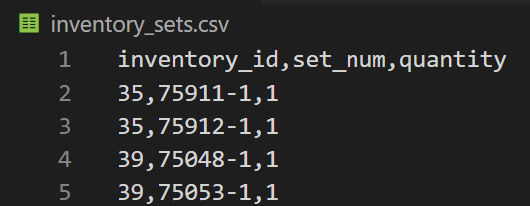

In [51]:
is_load="""
USING PERIODIC COMMIT 1000
LOAD CSV WITH HEADERS FROM 'file:///inventory_sets.csv' AS row
MERGE (i:Inventory {id:row.inventory_id})
MERGE (s:Set {id:row.set_num})
MERGE (i)-[r:CONTAINS]->(s)
ON CREATE SET
r.qty = row.quantity
"""
with driver.session() as session:
    results = session.run(is_load)

### Minifigs
Just like sets....

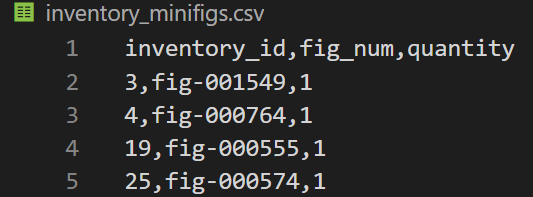

In [52]:
im_load="""
USING PERIODIC COMMIT 1000
LOAD CSV WITH HEADERS FROM 'file:///inventory_minifigs.csv' AS row
MERGE (i:Inventory {id:row.inventory_id})
MERGE (mf:MiniFigure {id:row.fig_num})
MERGE (i)-[r:CONTAINS]->(mf)
ON CREATE SET
r.qty = row.quantity
"""
with driver.session() as session:
    results = session.run(im_load)

### Parts

Just like those that come before...but different. The inventory shows the part number and the color used of that part, but it does not show the element id of that part number. For now, we will just add color as a property of that relationship and refactor the graph database in a later step.

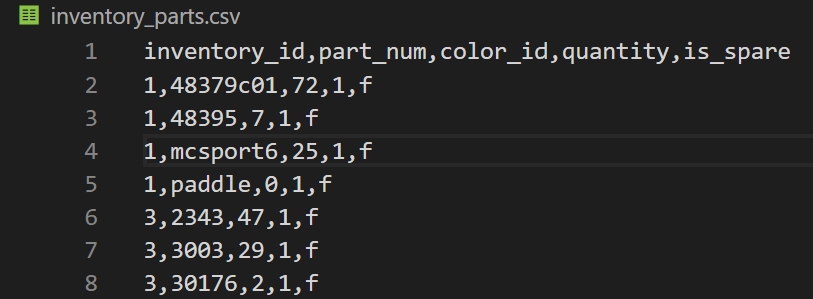

In [53]:
ip_load="""
USING PERIODIC COMMIT 1000
LOAD CSV WITH HEADERS FROM 'file:///inventory_parts.csv' AS row
MERGE (i:Inventory {id:row.inventory_id})
MERGE (p:Part {id:row.part_num})
MERGE (i)-[r:CONTAINS]->(p)
ON CREATE SET
r.qty = row.quantity,
r.color = row.color_id,
r.spare = row.is_spare
"""
with driver.session() as session:
    results = session.run(ip_load)

### Final Inventories

Now, we can finally import the last of the inventory files before any further refactoring. 

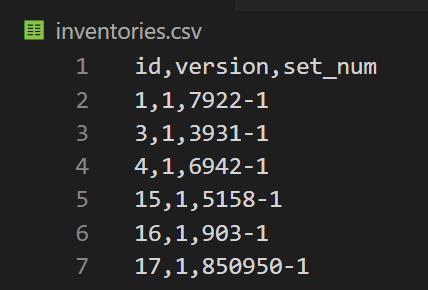

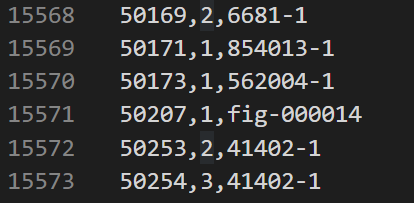

The thing to notice here, is that the set_num column does not just refer to (:Set), but also (:MiniFigure). Luckily, both of those labels use the "id" property. To make this import a bit more clean, we will do this in 2 imports.

In [55]:
iis_load="""
USING PERIODIC COMMIT 1000
LOAD CSV WITH HEADERS FROM 'file:///inventories.csv' AS row
MERGE (i:Inventory {id:row.id})
WITH i, row
MATCH (s:Set {id:row.set_num})
MERGE (i)-[:CONTAINS]->(s)
ON CREATE SET
i.version = row.version
"""
with driver.session() as session:
    results = session.run(iis_load)

In [56]:
iimf_load="""
USING PERIODIC COMMIT 1000
LOAD CSV WITH HEADERS FROM 'file:///inventories.csv' AS row
MERGE (i:Inventory {id:row.id})
WITH i, row
MATCH (mf:MiniFigure {id:row.set_num})
MERGE (i)-[:CONTAINS]->(mf)
ON CREATE SET
i.version = row.version
"""
with driver.session() as session:
    results = session.run(iimf_load)

With the inital imports complete, running a db.schema.visualization() will show the following:

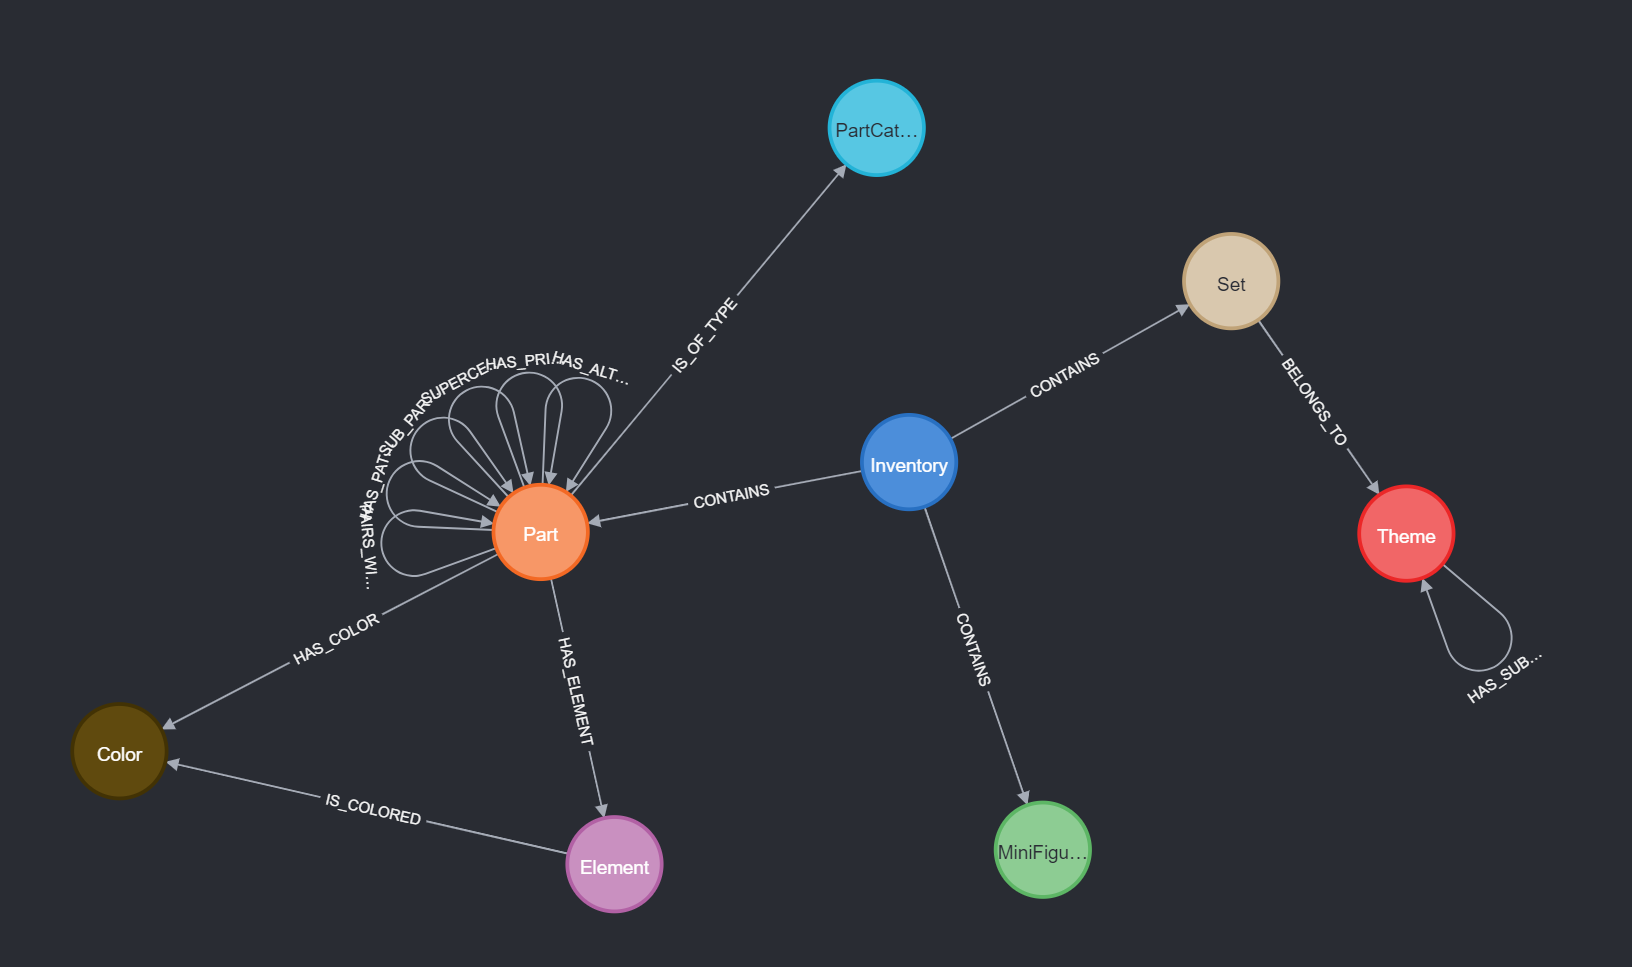

# Refactoring

One thing that should get cleaned up is that the (:Inventory) node references the (:Part) node. This is nice if I want a basic part number and am not concerned with the color. I could build the shape, but not have the style. We should refactor such that the inventory easily references the (:Element) node, which incorporates the shape (:Part) and style (:Color) to make easy the ordering of any needed components.
